In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')


# Define the path to the dataset directory
dataset_path = r'C:\Users\ADMIN\Downloads\Ann\Dataset\kaggle_3m'

In [2]:
# Function to derive label from image path
def get_label(image_path):
    return 1 if "1." in image_path else 0

# Function to preprocess images
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).resize(target_size)
    image = np.array(image) / 255.0
    return image

# Get all image paths
all_image_paths = glob(os.path.join(dataset_path, '**', '*.tif'), recursive=True)

# Separate image paths and mask paths
mask_paths = [path for path in all_image_paths if "_mask" in path]
image_paths = [path for path in all_image_paths if "_mask" not in path]

# Extract labels
labels = [get_label(path) for path in image_paths]

In [5]:
# Split the data into train, validation, and test sets
train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(image_paths, labels, test_size=0.15, random_state=42)
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(train_imgs, train_lbls, test_size=0.1, random_state=42)

# Preprocess the images
train_data = np.array([load_and_preprocess_image(path) for path in train_imgs])
val_data = np.array([load_and_preprocess_image(path) for path in val_imgs])
test_data = np.array([load_and_preprocess_image(path) for path in test_imgs])

# Calculate dataset sizesZ
train_size = len(train_imgs)
val_size = len(val_imgs)
test_size = len(test_imgs)
total_data_size = len(image_paths)

# Calculate percentages
train_percent = (train_size / total_data_size) * 100
val_percent = (val_size / total_data_size) * 100
test_percent = (test_size / total_data_size) * 100

# Display the percentages
print(f"Total number of images: {total_data_size}")
print(f"Training data: {train_size} images ({train_percent:.2f}%)")
print(f"Validation data: {val_size} images ({val_percent:.2f}%)")
print(f"Testing data: {test_size} images ({test_percent:.2f}%)")


Total number of images: 3929
Training data: 3005 images (76.48%)
Validation data: 334 images (8.50%)
Testing data: 590 images (15.02%)


Displaying images No disease- negative cases:


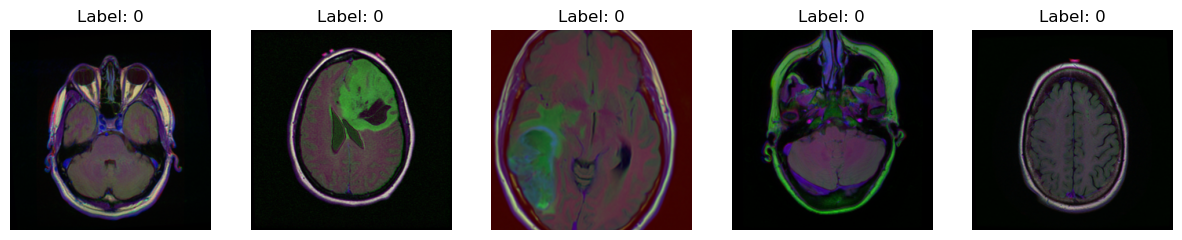

Displaying images with disease- positive cases:


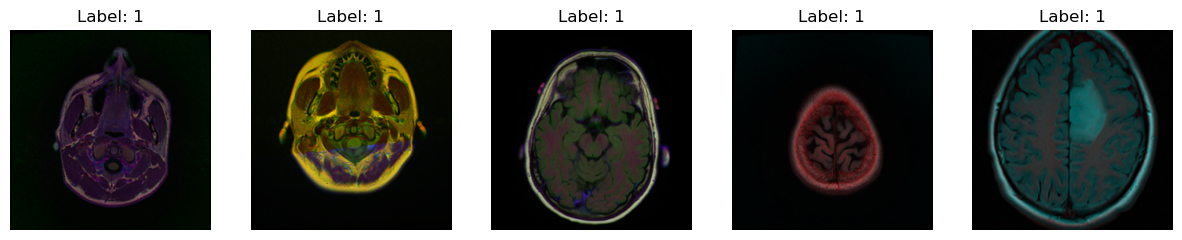

In [6]:
# Function to display images based on their labels
def display_label_images(images, labels, label_to_display, num_images=5):
    plt.figure(figsize=(15, 15))
    label_images = [img for img, lbl in zip(images, labels) if lbl == label_to_display]
    for i in range(min(num_images, len(label_images))):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(label_images[i])
        plt.title(f"Label: {label_to_display}")
        plt.axis("off")

# Display images with label 0
print("Displaying images No disease- negative cases:")
display_label_images(train_data, train_lbls, label_to_display=0, num_images=5)
plt.show()

# Display images with label 1
print("Displaying images with disease- positive cases:")
display_label_images(train_data, train_lbls, label_to_display=1, num_images=5)
plt.show()


In [7]:

# Define the CNN model
cnn_model = tf.keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


In [8]:
# Compile the model
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Adjust the parameters as needed
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Define callbacks
model_callbacks = [
    reduce_lr,
    callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath="cnn_model_best.keras", save_best_only=True, save_format='keras'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, verbose=1)
]


In [10]:
# Train the model
training_history = cnn_model.fit(train_data, np.array(train_lbls),
                                 epochs=10,
                                 batch_size=16,
                                 validation_data=(val_data, np.array(val_lbls)),
                                 callbacks=model_callbacks)


Epoch 1/10
188/188 [==============================] - 61s 298ms/step - loss: 2.3090 - accuracy: 0.8639 - val_loss: 2.3157 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 52s 278ms/step - loss: 0.5035 - accuracy: 0.8862 - val_loss: 1.8959 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 53s 284ms/step - loss: 0.4052 - accuracy: 0.8885 - val_loss: 0.4982 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 57s 303ms/step - loss: 0.3968 - accuracy: 0.8889 - val_loss: 0.4574 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 53s 285ms/step - loss: 0.3847 - accuracy: 0.8895 - val_loss: 0.4549 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 54s 288ms/step - loss: 0.3904 - accuracy: 0.8902 - val_loss: 0.4332 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 7/10
188/188 [==============================] 

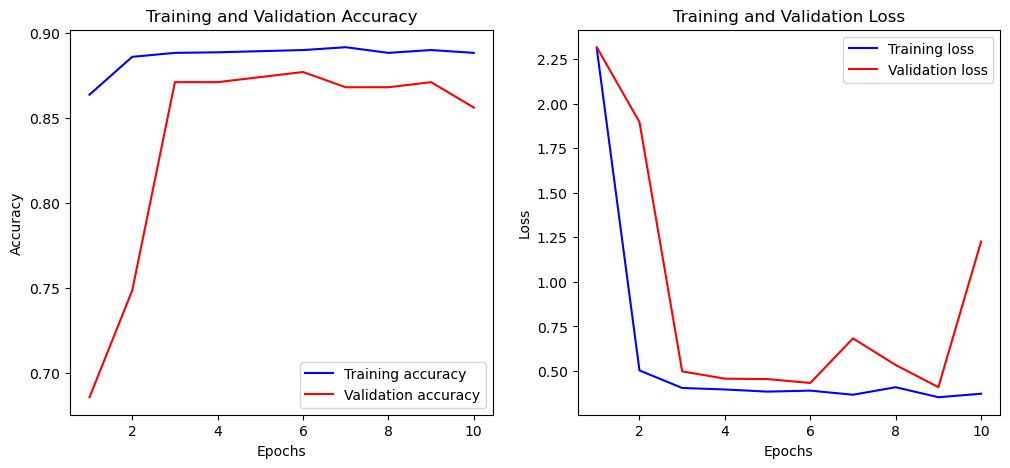

In [11]:
import matplotlib.pyplot as plt

# Retrieve the history dictionary
history_dict = training_history.history

# Extract accuracy and loss for both training and validation
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Determine the number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_data, np.array(test_lbls), verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


19/19 - 5s - loss: 0.7404 - accuracy: 0.8881 - 5s/epoch - 248ms/step
Test Loss: 0.7404339909553528
Test Accuracy: 0.8881356120109558


In [13]:

# Make predictions
predictions = cnn_model.predict(test_data)
predictions = (predictions > 0.5).astype(int)

19/19 [==============================] - 3s 118ms/step


In [14]:
# Calculate accuracy, confusion matrix, and classification report
final_accuracy = accuracy_score(test_lbls, predictions)
conf_matrix = confusion_matrix(test_lbls, predictions)
class_report = classification_report(test_lbls, predictions, target_names=["Negative", "Positive"])

print("Test Accuracy:", final_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Test Accuracy: 0.888135593220339
Confusion Matrix:
 [[516   9]
 [ 57   8]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.98      0.94       525
    Positive       0.47      0.12      0.20        65

    accuracy                           0.89       590
   macro avg       0.69      0.55      0.57       590
weighted avg       0.85      0.89      0.86       590



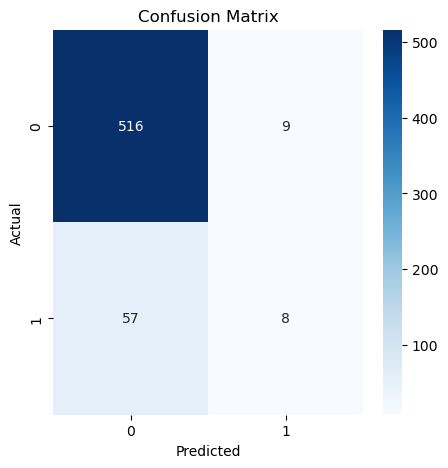

In [15]:
# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()